In [1]:
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting, enable_halving_search_cv  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingRandomSearchCV 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor 

# from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../../src')
import cb_utils
import cb_model_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

/Users/bp/miniforge3/envs/data-analytics/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


### Load raw data

In [2]:
query = f"select * from junk.ml_training_samples_20250218;"
df = cb_utils.sql_query_to_df(query, use_cache=True, source='msh_analytics')

Pulling query from db


In [3]:
df.head()

,payer_id,period_number,member_id,pre_elg_days,age_ft,is_male_ft,is_female_ft,ip_tc_pre_pmpm_ft,ed_tc_pre_pmpm_ft,snf_tc_pre_pmpm_ft,icf_tc_pre_pmpm_ft,hh_tc_pre_pmpm_ft,out_tc_pre_pmpm_ft,pro_tc_pre_pmpm_ft,hcbs_tc_pre_pmpm_ft,sphs_tc_pre_pmpm_ft,amb_tc_pre_pmpm_ft,dme_tc_pre_pmpm_ft,hosp_tc_pre_pmpm_ft,dialysis_ddos_pre_pmpm_ft,pulmonar_ddos_pre_pmpm_ft,copd_ddos_pre_pmpm_ft,chf_ddos_pre_pmpm_ft,heart_ddos_pre_pmpm_ft,cancer_ddos_pre_pmpm_ft,ckd_ddos_pre_pmpm_ft,esrd_ddos_pre_pmpm_ft,hyperlipid_ddos_pre_pmpm_ft,diab_ddos_pre_pmpm_ft,alzh_ddos_pre_pmpm_ft,dementia_ddos_pre_pmpm_ft,neurocognitive_ddos_pre_pmpm_ft,stroke_ddos_pre_pmpm_ft,hypertension_ddos_pre_pmpm_ft,fall_ddos_pre_pmpm_ft,transplant_ddos_pre_pmpm_ft,liver_ddos_pre_pmpm_ft,hippfract_ddos_pre_pmpm_ft,depression_ddos_pre_pmpm_ft,psychosis_ddos_pre_pmpm_ft,drug_ddos_pre_pmpm_ft,alcohol_ddos_pre_pmpm_ft,paralysis_ddos_pre_pmpm_ft,hemophilia_ddos_pre_pmpm_ft,pressure_ulcer_ddos_pre_pmpm_ft,tbi_ddos_pre_pmpm_ft,obese_ddos_pre_pmpm_ft,ip_tc_pre_q1_pmpm_ft,ed_tc_pre_q1_pmpm_ft,snf_tc_pre_q1_pmpm_ft,icf_tc_pre_q1_pmpm_ft,hh_tc_pre_q1_pmpm_ft,out_tc_pre_q1_pmpm_ft,pro_tc_pre_q1_pmpm_ft,hcbs_tc_pre_q1_pmpm_ft,sphs_tc_pre_q1_pmpm_ft,amb_tc_pre_q1_pmpm_ft,dme_tc_pre_q1_pmpm_ft,hosp_tc_pre_q1_pmpm_ft,dialysis_ddos_pre_q1_pmpm_ft,pulmonar_ddos_pre_q1_pmpm_ft,copd_ddos_pre_q1_pmpm_ft,chf_ddos_pre_q1_pmpm_ft,heart_ddos_pre_q1_pmpm_ft,cancer_ddos_pre_q1_pmpm_ft,ckd_ddos_pre_q1_pmpm_ft,esrd_ddos_pre_q1_pmpm_ft,hyperlipid_ddos_pre_q1_pmpm_ft,diab_ddos_pre_q1_pmpm_ft,alzh_ddos_pre_q1_pmpm_ft,dementia_ddos_pre_q1_pmpm_ft,neurocognitive_ddos_pre_q1_pmpm_ft,stroke_ddos_pre_q1_pmpm_ft,hypertension_ddos_pre_q1_pmpm_ft,fall_ddos_pre_q1_pmpm_ft,transplant_ddos_pre_q1_pmpm_ft,liver_ddos_pre_q1_pmpm_ft,hippfract_ddos_pre_q1_pmpm_ft,depression_ddos_pre_q1_pmpm_ft,psychosis_ddos_pre_q1_pmpm_ft,drug_ddos_pre_q1_pmpm_ft,alcohol_ddos_pre_q1_pmpm_ft,paralysis_ddos_pre_q1_pmpm_ft,hemophilia_ddos_pre_q1_pmpm_ft,pressure_ulcer_ddos_pre_q1_pmpm_ft,tbi_ddos_pre_q1_pmpm_ft,obese_ddos_pre_q1_pmpm_ft,ip_ddos_pre_q1_pmpm_ft,ed_ddos_pre_q1_pmpm_ft,snf_ddos_pre_q1_pmpm_ft,ip_span_ddos_pre_q1_pmpm_ft,snf_span_ddos_pre_q1_pmpm_ft,ip_tc_pre_q2_pmpm_ft,ed_tc_pre_q2_pmpm_ft,snf_tc_pre_q2_pmpm_ft,icf_tc_pre_q2_pmpm_ft,hh_tc_pre_q2_pmpm_ft,out_tc_pre_q2_pmpm_ft,pro_tc_pre_q2_pmpm_ft,hcbs_tc_pre_q2_pmpm_ft,sphs_tc_pre_q2_pmpm_ft,amb_tc_pre_q2_pmpm_ft,dme_tc_pre_q2_pmpm_ft,hosp_tc_pre_q2_pmpm_ft,dialysis_ddos_pre_q2_pmpm_ft,pulmonar_ddos_pre_q2_pmpm_ft,copd_ddos_pre_q2_pmpm_ft,chf_ddos_pre_q2_pmpm_ft,heart_ddos_pre_q2_pmpm_ft,cancer_ddos_pre_q2_pmpm_ft,ckd_ddos_pre_q2_pmpm_ft,esrd_ddos_pre_q2_pmpm_ft,hyperlipid_ddos_pre_q2_pmpm_ft,diab_ddos_pre_q2_pmpm_ft,alzh_ddos_pre_q2_pmpm_ft,dementia_ddos_pre_q2_pmpm_ft,neurocognitive_ddos_pre_q2_pmpm_ft,stroke_ddos_pre_q2_pmpm_ft,hypertension_ddos_pre_q2_pmpm_ft,fall_ddos_pre_q2_pmpm_ft,transplant_ddos_pre_q2_pmpm_ft,liver_ddos_pre_q2_pmpm_ft,hippfract_ddos_pre_q2_pmpm_ft,depression_ddos_pre_q2_pmpm_ft,psychosis_ddos_pre_q2_pmpm_ft,drug_ddos_pre_q2_pmpm_ft,alcohol_ddos_pre_q2_pmpm_ft,paralysis_ddos_pre_q2_pmpm_ft,hemophilia_ddos_pre_q2_pmpm_ft,pressure_ulcer_ddos_pre_q2_pmpm_ft,tbi_ddos_pre_q2_pmpm_ft,obese_ddos_pre_q2_pmpm_ft,ip_ddos_pre_q2_pmpm_ft,ed_ddos_pre_q2_pmpm_ft,snf_ddos_pre_q2_pmpm_ft,ip_span_ddos_pre_q2_pmpm_ft,snf_span_ddos_pre_q2_pmpm_ft,ip_tc_pre_q3_pmpm_ft,ed_tc_pre_q3_pmpm_ft,snf_tc_pre_q3_pmpm_ft,icf_tc_pre_q3_pmpm_ft,hh_tc_pre_q3_pmpm_ft,out_tc_pre_q3_pmpm_ft,pro_tc_pre_q3_pmpm_ft,hcbs_tc_pre_q3_pmpm_ft,sphs_tc_pre_q3_pmpm_ft,amb_tc_pre_q3_pmpm_ft,dme_tc_pre_q3_pmpm_ft,hosp_tc_pre_q3_pmpm_ft,dialysis_ddos_pre_q3_pmpm_ft,pulmonar_ddos_pre_q3_pmpm_ft,copd_ddos_pre_q3_pmpm_ft,chf_ddos_pre_q3_pmpm_ft,heart_ddos_pre_q3_pmpm_ft,cancer_ddos_pre_q3_pmpm_ft,ckd_ddos_pre_q3_pmpm_ft,esrd_ddos_pre_q3_pmpm_ft,hyperlipid_ddos_pre_q3_pmpm_ft,diab_ddos_pre_q3_pmpm_ft,alzh_ddos_pre_q3_pmpm_ft,dementia_ddos_pre_q3_pmpm_ft,neurocognitive_ddos_pre_q3_pmpm_ft,stroke_ddos_pre_q3_p

In [4]:
df.shape

(1765592, 230)

In [5]:
df.member_id.nunique()

146076

### Train test split

In [6]:
train_pct = 0.8
# Get unique member IDs and randomly split them
all_members = df.member_id.unique()
np.random.seed(42)
train_members = np.random.choice(all_members, size=int(len(all_members) * train_pct), replace=False)
test_members = np.setdiff1d(all_members, train_members)

# Split dataframes based on member lists
train_df = df[df.member_id.isin(train_members)].copy()
test_df = df[df.member_id.isin(test_members)].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nUnique members in train: {train_df.member_id.nunique()}")
print(f"Unique members in test: {test_df.member_id.nunique()}")



Train shape: (1411865, 230)
Test shape: (353727, 230)

Unique members in train: 116860
Unique members in test: 29216


In [7]:

feature_cols = [col for col in train_df.columns if col in ['age_ft', 'is_female_ft', 'is_male_ft'] or '_q' in col]
feature_cols

['age_ft',
 'is_male_ft',
 'is_female_ft',
 'ip_tc_pre_q1_pmpm_ft',
 'ed_tc_pre_q1_pmpm_ft',
 'snf_tc_pre_q1_pmpm_ft',
 'icf_tc_pre_q1_pmpm_ft',
 'hh_tc_pre_q1_pmpm_ft',
 'out_tc_pre_q1_pmpm_ft',
 'pro_tc_pre_q1_pmpm_ft',
 'hcbs_tc_pre_q1_pmpm_ft',
 'sphs_tc_pre_q1_pmpm_ft',
 'amb_tc_pre_q1_pmpm_ft',
 'dme_tc_pre_q1_pmpm_ft',
 'hosp_tc_pre_q1_pmpm_ft',
 'dialysis_ddos_pre_q1_pmpm_ft',
 'pulmonar_ddos_pre_q1_pmpm_ft',
 'copd_ddos_pre_q1_pmpm_ft',
 'chf_ddos_pre_q1_pmpm_ft',
 'heart_ddos_pre_q1_pmpm_ft',
 'cancer_ddos_pre_q1_pmpm_ft',
 'ckd_ddos_pre_q1_pmpm_ft',
 'esrd_ddos_pre_q1_pmpm_ft',
 'hyperlipid_ddos_pre_q1_pmpm_ft',
 'diab_ddos_pre_q1_pmpm_ft',
 'alzh_ddos_pre_q1_pmpm_ft',
 'dementia_ddos_pre_q1_pmpm_ft',
 'neurocognitive_ddos_pre_q1_pmpm_ft',
 'stroke_ddos_pre_q1_pmpm_ft',
 'hypertension_ddos_pre_q1_pmpm_ft',
 'fall_ddos_pre_q1_pmpm_ft',
 'transplant_ddos_pre_q1_pmpm_ft',
 'liver_ddos_pre_q1_pmpm_ft',
 'hippfract_ddos_pre_q1_pmpm_ft',
 'depression_ddos_pre_q1_pmpm_ft',
 'psycho

In [8]:
# Get feature columns ending in _ft
# feature_cols = [col for col in train_df.columns if col.endswith('_ft')]
target_col = 'tc_pmpm_tg'

# Create feature matrix X and target vector y
X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# Import required modules
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Initialize scaler and model
scaler = StandardScaler()
model = LinearRegression()

# Setup k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # Split data
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Scale features
    X_fold_train_scaled = scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = scaler.transform(X_fold_val)
    
    # Train model
    model.fit(X_fold_train_scaled, y_fold_train)
    
    # Make predictions
    y_pred = model.predict(X_fold_val_scaled)
    
    # Calculate R2 score
    r2 = r2_score(y_fold_val, y_pred)
    cv_scores.append(r2)
    
    print(f"Fold {fold + 1} R² Score: {r2:.4f}")

print(f"\nMean CV R² Score: {np.mean(cv_scores):.4f}")
print(f"Std CV R² Score: {np.std(cv_scores):.4f}")

# Train final model on full training set
X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': model.coef_
})
feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# # Evaluate on test set
# y_pred_test = model.predict(X_test_scaled)
# test_r2 = r2_score(y_test, y_pred_test)
# test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print(f"\nTest Set R² Score: {test_r2:.4f}")
# print(f"Test Set RMSE: {test_rmse:.4f}")


Fold 1 R² Score: 0.1918
Fold 2 R² Score: 0.1992
Fold 3 R² Score: 0.2101
Fold 4 R² Score: 0.1799
Fold 5 R² Score: 0.2117

Mean CV R² Score: 0.1986
Std CV R² Score: 0.0118

Top 10 Most Important Features:
                    feature   coefficient  abs_coefficient
6     icf_tc_pre_q1_pmpm_ft  1.001994e+13     1.001994e+13
11   sphs_tc_pre_q1_pmpm_ft  9.794828e+12     9.794828e+12
51    icf_tc_pre_q2_pmpm_ft  6.748248e+12     6.748248e+12
10   hcbs_tc_pre_q1_pmpm_ft  4.041941e+12     4.041941e+12
55   hcbs_tc_pre_q2_pmpm_ft  2.969397e+12     2.969397e+12
101  sphs_tc_pre_q3_pmpm_ft  1.919973e+12     1.919973e+12
96    icf_tc_pre_q3_pmpm_ft  1.754135e+12     1.754135e+12
100  hcbs_tc_pre_q3_pmpm_ft  4.676798e+11     4.676798e+11
1                is_male_ft  2.300811e+11     2.300811e+11
2              is_female_ft  2.300811e+11     2.300811e+11


In [9]:
# Initialize HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(random_state=42)

# Initialize cross-validation scores list
cv_scores = []

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # Split data
    X_fold_train = X_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_train = y_train.iloc[train_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Scale features
    X_fold_train_scaled = scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = scaler.transform(X_fold_val)
    
    # Train model
    model.fit(X_fold_train_scaled, y_fold_train)
    
    # Make predictions
    y_pred = model.predict(X_fold_val_scaled)
    
    # Calculate R2 score
    r2 = r2_score(y_fold_val, y_pred)
    cv_scores.append(r2)
    
    print(f"Fold {fold + 1} R² Score: {r2:.4f}")

print(f"\nMean CV R² Score: {np.mean(cv_scores):.4f}")
print(f"Std CV R² Score: {np.std(cv_scores):.4f}")

Fold 1 R² Score: 0.2313
Fold 2 R² Score: 0.2417
Fold 3 R² Score: 0.2486
Fold 4 R² Score: 0.2259
Fold 5 R² Score: 0.2483

Mean CV R² Score: 0.2391
Std CV R² Score: 0.0091


In [10]:
# Calculate permutation feature importance
from sklearn.inspection import permutation_importance
# Split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2,
    random_state=42
)

# Scale the features
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# Train model on final training set
model.fit(X_train_final_scaled, y_train_final)

# Evaluate on validation set
y_val_pred = model.predict(X_val_scaled)
val_r2 = r2_score(y_val, y_val_pred)
print(f"\nValidation Set R² Score: {val_r2:.4f}")

# Calculate permutation importance on validation set
result = permutation_importance(
    model, X_fold_val_scaled, y_fold_val,
    n_repeats=10,
    random_state=42
)

# Create DataFrame of feature importances
importances = pd.DataFrame(
    {'feature': X_train.columns,
     'importance': result.importances_mean,
     'std': result.importances_std}
)
importances = importances.sort_values('importance', ascending=False)




Validation Set R² Score: 0.2321


In [11]:

# %% cell 12 code

# Display top 20 most important features
print("Top 20 Most Important Features:")
print(importances.head(20))

# %% cell 13 code


Top 20 Most Important Features:
                         feature  importance       std
143        out_tc_pre_q4_pmpm_ft    0.056211  0.000488
144        pro_tc_pre_q4_pmpm_ft    0.031901  0.000772
98         out_tc_pre_q3_pmpm_ft    0.017326  0.000436
0                         age_ft    0.016396  0.000432
155   cancer_ddos_pre_q4_pmpm_ft    0.013845  0.000168
53         out_tc_pre_q2_pmpm_ft    0.011696  0.000157
142         hh_tc_pre_q4_pmpm_ft    0.009830  0.000109
148        dme_tc_pre_q4_pmpm_ft    0.009273  0.000592
8          out_tc_pre_q1_pmpm_ft    0.008437  0.000208
99         pro_tc_pre_q3_pmpm_ft    0.007788  0.000459
149       hosp_tc_pre_q4_pmpm_ft    0.006343  0.000171
181  ip_span_ddos_pre_q4_pmpm_ft    0.006212  0.000337
103        dme_tc_pre_q3_pmpm_ft    0.003984  0.000173
154    heart_ddos_pre_q4_pmpm_ft    0.003407  0.000193
159     diab_ddos_pre_q4_pmpm_ft    0.003367  0.000156
152     copd_ddos_pre_q4_pmpm_ft    0.003285  0.000095
54         pro_tc_pre_q2_pmpm_ft 

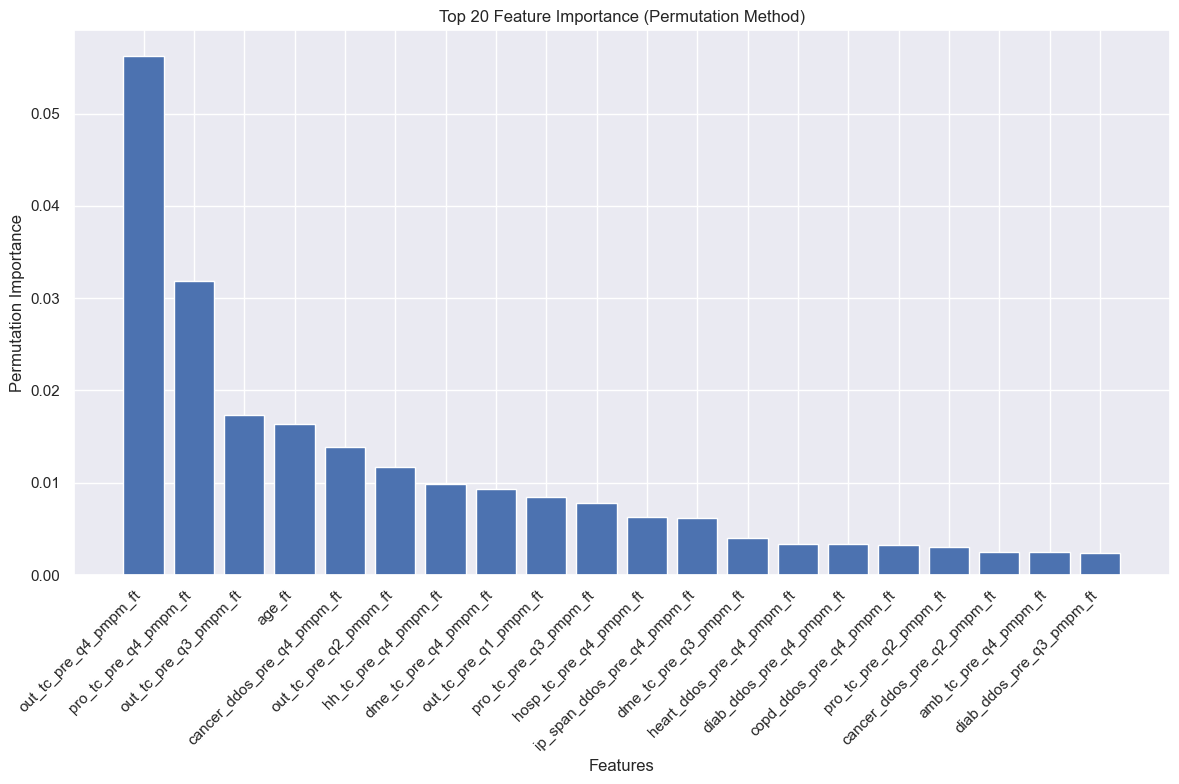

In [12]:

# Create bar plot of feature importance
plt.figure(figsize=(12, 8))
plt.bar(range(20), importances['importance'][:20])
plt.xticks(range(20), importances['feature'][:20], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Permutation Importance')
plt.title('Top 20 Feature Importance (Permutation Method)')
plt.tight_layout()
plt.show()


In [17]:
# did not do as well as the high level features.
# try just the top quarter features with high level to see if any improvement

feature_cols = [col for col in train_df.columns if col.endswith('_ft') and '_q' not in col]
feature_cols = feature_cols + ['ip_span_ddos_pre_q4_pmpm_ft']

In [18]:
# Initialize HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(random_state=42)

# Initialize cross-validation scores list
cv_scores = []

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # Split data
    X_fold_train = X_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_train = y_train.iloc[train_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Scale features
    X_fold_train_scaled = scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = scaler.transform(X_fold_val)
    
    # Train model
    model.fit(X_fold_train_scaled, y_fold_train)
    
    # Make predictions
    y_pred = model.predict(X_fold_val_scaled)
    
    # Calculate R2 score
    r2 = r2_score(y_fold_val, y_pred)
    cv_scores.append(r2)
    
    print(f"Fold {fold + 1} R² Score: {r2:.4f}")

print(f"\nMean CV R² Score: {np.mean(cv_scores):.4f}")
print(f"Std CV R² Score: {np.std(cv_scores):.4f}")


Fold 1 R² Score: 0.2502
Fold 2 R² Score: 0.2657
Fold 3 R² Score: 0.2636
Fold 4 R² Score: 0.2613
Fold 5 R² Score: 0.2678

Mean CV R² Score: 0.2617
Std CV R² Score: 0.0062


In [ ]:
# no better than just high level features. Stick with original